In [ ]:
class Params:
    def __init__(self):
        self.dir='./dataset/IPIN2023_T3_TrainingTrials'
        self.calibration_coor='./dataset/IPIN2023_T3_SupplementaryMaterials/01 - Calibration Floormaps/references.csv'

p = Params()

In [2]:
import os
import pandas as pd
from functions import get_sub_files

In [ ]:
sub_files = get_sub_files(p.dir)
posi_data_list = []
# 循环中收集数据到一个列表，然后在循环结束后创建一个DataFrame
for file_path in sub_files:
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.startswith('POSI'):
                    parts = line.strip().split(';')
                    timestamp = float(parts[1])
                    latitude = float(parts[3])
                    longitude = float(parts[4])
                    floor_id = int(parts[5])
                    building_id = int(parts[6])
                    file_name = os.path.basename(file_path)
                    posi_data_list.append({
                        'Timestamp': timestamp,
                        'Latitude': latitude,
                        'Longitude': longitude,
                        'FloorID': floor_id,
                        'BuildingID': building_id,
                        'FileName': file_name
                    })
    except Exception as e:
        print(f"在读取{file_path}时发生错误: {e}")
posi_data = pd.DataFrame(posi_data_list)
print("the number of posi data is:",len(posi_data))
# Count the number of POSI data for each FloorID
# floor_count = posi_data['FloorID'].value_counts().sort_index()
floor_count = posi_data['FloorID'].value_counts().sort_index().reset_index()
# print(floor_count)
floor_count.columns = ['FloorID', 'Count']
print(floor_count)

Number of files in this dir: 53
the number of posi data is: 762
   FloorID  Count
0       -2    448
1       -1     16
2        0    298


In [4]:
# groupby根据一个或多个列的值对数据进行分组
# size方法用于计算每个组的大小（即每个组的行数）。此方法返回一个Series对象，索引是分组列的值，值是每组的大小。
# reset_index方法用于重置Series对象的索引，并将现有的索引列转移到DataFrame的列中。创建一个新的DataFrame，其中包含原始的分组列和一个名为'Frequency'的新列，该列包含每个组的大小（即每个唯一经纬度对的频率）。
coordinate_frequency = posi_data.groupby(['Latitude', 'Longitude']).size().reset_index(name='Frequency')
#sort_values根据一个或多个列的值对数据进行排序。在这里，它根据'Frequency'列的值进行排序
coordinate_frequency = coordinate_frequency.sort_values(by='Frequency', ascending=False).reset_index(drop=True)
print("一共有",coordinate_frequency.shape[0],"个真实坐标点")
print(coordinate_frequency.head(5))

一共有 77 个真实坐标点
    Latitude  Longitude  Frequency
0  49.461132  11.111006         32
1  49.461088  11.110832         24
2  49.461053  11.111052         22
3  49.461142  11.110943         16
4  49.461327  11.111581         16


参考点坐标：
   pointID        Lat        Lon
0     9001  49.461149  11.110284
1     9002  49.461238  11.110826
2     9003  49.461377  11.111395
3     9004  49.461331  11.111422
4     9005  49.461445  11.111884
5     9006  49.461240  11.112004
6     9007  49.461026  11.111142
7     9008  49.460858  11.110454
8     9999  49.461142  11.110943
坐标点的统计度量：
         Latitude   Longitude
count  762.000000  762.000000
mean    49.461161   11.111072
std      0.000117    0.000351
min     49.460900   11.110472
25%     49.461074   11.110804
50%     49.461176   11.111027
75%     49.461257   11.111337
max     49.461330   11.111855


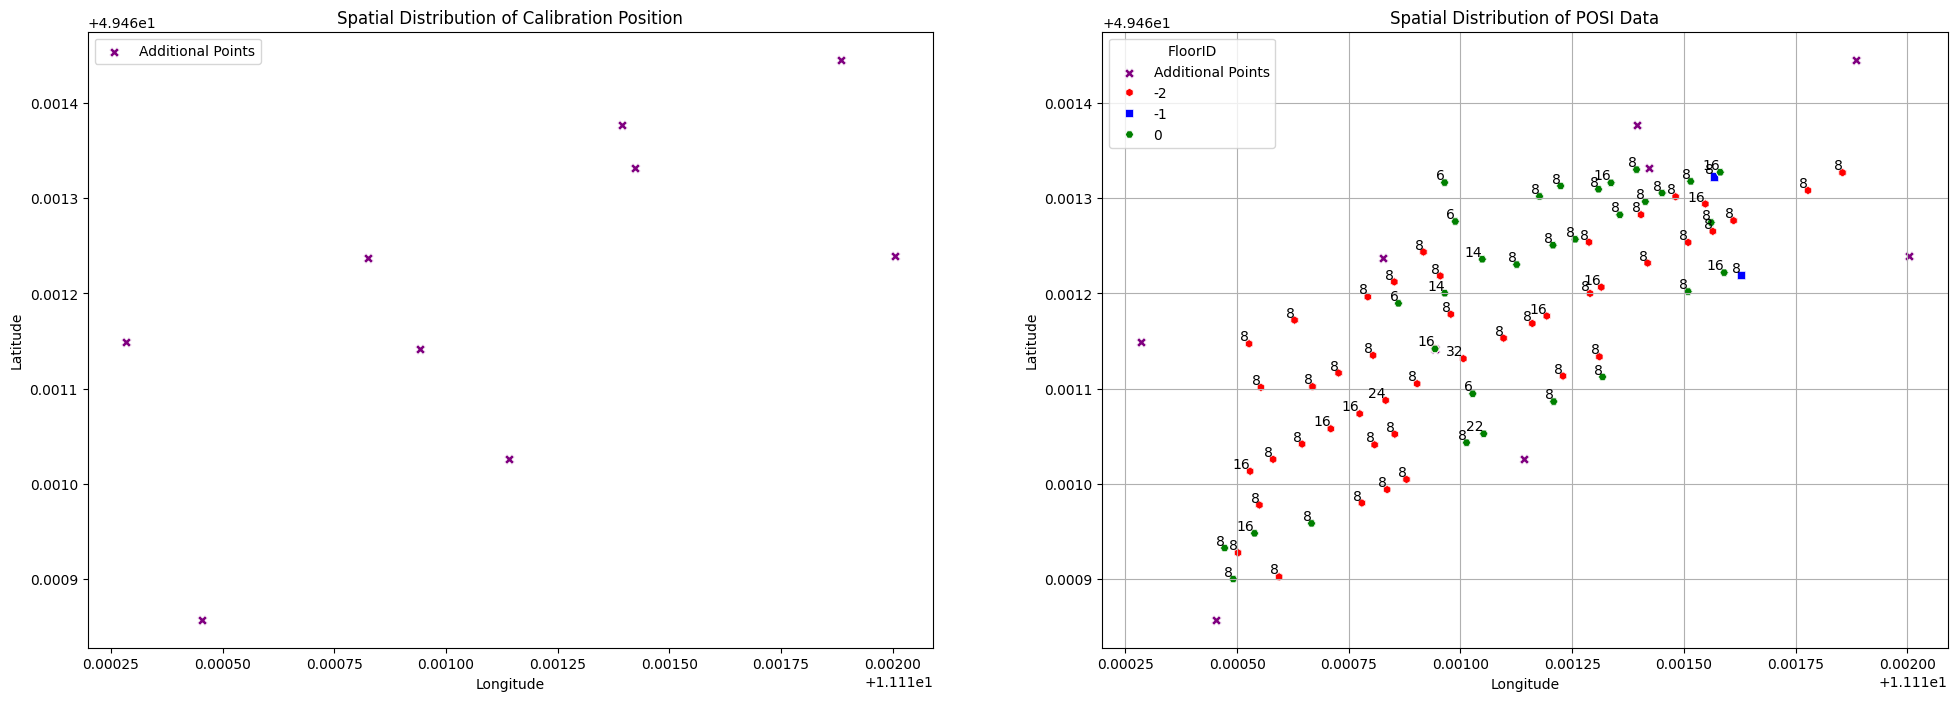

In [5]:
# 提取Latitude和Longitude列，并计算各种统计度量，如均值、标准偏差、最小值、25th 百分位数、中位数（50th 百分位数）、75th 百分位数和最大值。
statistical_summary = posi_data[['Latitude', 'Longitude']].describe()

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

fig, axes = plt.subplots(1, 2, figsize=(24, 8))

calibration_data = pd.read_csv(p.calibration_coor)
print("参考点坐标：")
print(calibration_data)
# plt.figure(figsize=(6, 4))#(12,8)
sns.scatterplot(data=calibration_data, 
                x='Lon', y='Lat', color='purple', marker='X', s=50, 
                label='Additional Points',
                ax=axes[0])
sns.scatterplot(data=calibration_data, 
                x='Lon', y='Lat', color='purple', marker='X', s=50, 
                label='Additional Points',
                ax=axes[1])
# plt.title('Spatial Distribution of calibration position')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
axes[0].set_title('Spatial Distribution of Calibration Position')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

posi_counts = Counter(list(zip(posi_data['Latitude'], posi_data['Longitude'])))
# 使用zip来将df中的两列配对。这将创建一个迭代器，其中每个元素都是一个包含两个元素（纬度和经度）的元组
# zip对象是一个迭代器，只能遍历一次。list将其转换为列表允许多次使用
# Counter 是一个字典子类，用于计数可哈希对象。在这里，计算列表中每个（纬度，经度）元组的出现次数。
color_dict = {-2: 'red', -1: 'blue', 0: 'green'}
style_dict = {-2: 'h', -1: 's', 0: 'H'}
# plt.figure(figsize=(6, 4)) # 在调用 sns.scatterplot() 之前设置图形大小，这样 Seaborn 将在这个图形上绘制
sns.scatterplot(data=posi_data, 
                x='Longitude', 
                y='Latitude', 
                hue='FloorID',      # 设置颜色
                # size='size_var',  # 设置大小
                style='FloorID',    # 设置形状
                palette=color_dict, # 指定颜色字典
                markers=style_dict, # 指定形状字典
                sizes=(100, 400),   # 设置大小范围,类似归一化
                ax=axes[1])  # 指定第二个子图  
# plt.title('Spatial Distribution of POSI Data')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.legend(title='FloorID', bbox_to_anchor=(1, 1), loc='upper left')
# plt.grid(True)
axes[1].set_title('Spatial Distribution of POSI Data')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].legend(title='FloorID', bbox_to_anchor=(0, 1), loc='upper left')
axes[1].grid(True)
# 设置 x 轴和 y 轴刻度，从而间接设置网格线间距
# plt.xticks(np.arange(0, 11, 1))  # x 轴从 0 到 10，每隔 1 一个刻度（即网格线）
# plt.yticks(np.arange(-1, 1.1, 0.2))  # y 轴从 -1 到 1，每隔 0.2 一个刻度（即网格线）


# 在第二个子图上添加点的出现次数
for point, count in posi_counts.items():
    latitude, longitude = point
    axes[1].text(longitude, latitude, str(count), fontsize=10, ha='right', va='bottom')

print("坐标点的统计度量：")
print(statistical_summary)
# plt.tight_layout()  # 调整子图的布局以防止重叠
plt.show()
